# Q-Learning Implementation for **Frozen Lake** using OpenAI Gym

## Frozen Lake Game

Winter is here! You and your friends were tossing a frisbee at the park when a wild throw sent it flying into the middle of a frozen lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water.

Due to an international frisbee shortage, it is absolutely imperative that you navigate across the lake and retrieve the frisbee. However, the ice is slippery, so you won’t always move in the direction you intend.

### Game Grid
The lake's surface is represented as a grid:

```
SFFF
FHFH
FFFH
HFFG
```

Each cell in the grid represents a different type of terrain:

| Symbol | Description                      | Reward |
|--------|----------------------------------|--------|
| S      | Agent's starting point - safe   | 0      |
| F      | Frozen surface - safe           | 0      |
| H      | Hole - game over                 | 0      |
| G      | Goal - game over (frisbee found) | 1      |

### Gameplay
- The agent can move in four directions: **left, right, up, and down**.
- The episode ends when the agent reaches the **goal (G)** or falls into a **hole (H)**.
- The agent receives a **reward of 1** upon reaching the goal, and **0 otherwise**.

### Objective
Your **goal** is to successfully navigate across the frozen lake, avoid the holes, and retrieve the frisbee. Be careful—the ice is slippery, meaning movement may not always go as planned!

Good luck retrieving your frisbee!

## Dependencies

In [1]:
import numpy as np
import gymnasium as gym
import random
import time
from IPython.display import clear_output

## Envronment and Q-table setup

Creating the environment

In [2]:
env = gym.make("FrozenLake-v1", render_mode="ansi")

In [3]:
state_space_size = env.observation_space.n
action_space_size = env.action_space.n

# Initialize Q-Table with zeros
q_table = np.zeros((state_space_size, action_space_size))

print(f"Action space size: {action_space_size}")
print(f"State space size: {state_space_size}")

print("\nInitial Q-Table:")
print(q_table)

Action space size: 4
State space size: 16

Initial Q-Table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Initializing Q-learning parameters

In [4]:
num_episodes = 10000  # Total episodes for agent to play during training

max_steps_per_episode = 100  # Max steps allowed per episode

learning_rate = 0.1  # Learning rate (α) for which the agent updates Q-values

discount_rate = 0.99  # Discount rate Gamma (γ) : Future reward discount factor)

exploration_rate = 1  # Epsilon (ε) : Initial exploration rate
max_exploration_rate = 1  # Max exploration rate
min_exploration_rate = 0.01  # Min exploration rate

exploration_decay_rate = 0.01  # Rate at which exploration rate decays

## Q-learning algorithm training loop

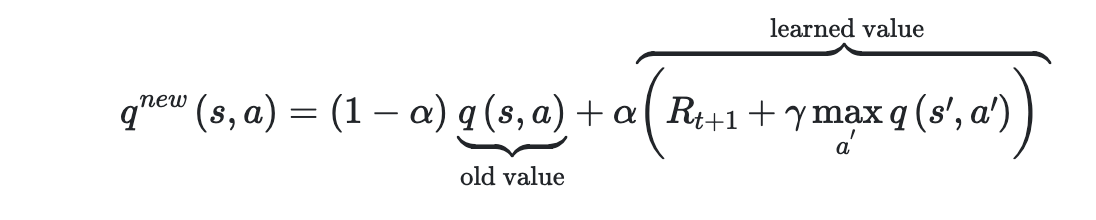

**Q-learning Update Rule (General Form):**
* This form shows the general update rule, where the new Q-value is a weighted average of the old Q-value and the learned value (immediate reward plus discounted maximum future Q-value).

$$q^{new}(s, a) = (1 - \alpha) q(s, a) + \alpha \left( R_{t+1} + \gamma \max_{a'} q(s', a') \right)$$


**Q-learning Update Rule (Table Representation):**
* This form explicitly shows how the update is applied to a Q-table, where `q_table[s, a]` represents the Q-value for taking action `a` in state `s`. The variables `r`, `s`, and `s'` are used instead of `R_{t+1}`, `s`, and `s'` respectively, but they have the same meaning.

$$q_{\text{table}}[s, a] = q_{\text{table}}[s, a] + \alpha \left( r + \gamma \max_{a'} q_{\text{table}}[s', a'] - q_{\text{table}}[s, a] \right)$$



In [5]:
rewards_all_episodes = []

# For life or until learning is stopped
for episode in range(num_episodes):
    # initialize new episode params
    state = env.reset()[0]
    done = False
    rewards_current_episode = 0

    for step in range(max_steps_per_episode):
        # >> Choose an action a in the current world state (s)
        ## First we randomize a number between 0 and 1
        exp_exp_tradeoff = random.uniform(0, 1)

        ## If this number > greater than epsilon -->  Exploitation: choose the action with max Q-value for current state
        if exp_exp_tradeoff > exploration_rate:
            action = np.argmax(q_table[state, :])
        # Else we choose a random action (Exploration)
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, truncated, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # q_table[new_state,:] : all the actions we can take from new state
        current_q_value = q_table[state, action]
        # print(
        #     f"Current Q-value for taking action {action} in state {state}: {current_q_value}"
        # )

        # Find the best possible Q-value we can get in the next state
        max_future_q_value = np.max(q_table[new_state, :])
        # print(f"Max Q-value in next state {new_state}: {max_future_q_value}")
        # print(
        #     f"Q-values for all actions in next state {new_state}: {q_table[new_state, :]}"
        # )

        # Calculate the 'learning signal' or TD error
        # How much better did we expect the future to be compared to what we thought?
        td_error = reward + discount_rate * max_future_q_value - current_q_value
        # print(f"Learning signal (TD error): {td_error}")

        # Update the Q-value, moving it a little bit towards our new expectation
        # learning_rate controls how much we move
        updated_q_value = current_q_value + learning_rate * td_error

        # Alternatively, we could write this as:
        # This way of writing shows the weighted average between the old value and the new 'learned value'
        # updated_q_value = (1 - learning_rate) * current_q_value + learning_rate * (reward + discount_rate * max_future_q_value)
        # print(f"Updated Q-value: {updated_q_value}")

        # Update the Q-table with the new Q-value for the current state and action
        q_table[state, action] = updated_q_value

        ### Equivalent to above in a single calculation
        # q_table[state, action] = q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]) - q_table[state, action])
        ###

        # Update the state to the new state
        state = new_state

        # Add the reward to the total reward for this episode
        rewards_current_episode += reward

        # print(
        #     f"Step: {step}, State: {state}, Action: {action}, Reward: {reward}, New State: {new_state}"
        # )

        # If done (or if agent is dead) : finish episode
        if done == True or truncated == True:
            break

    # Once an episode is finished, we need to update our exploration_rate using exponential decay
    # The exploration rate decreases or decays at a rate proportional to its current value
    exploration_rate = min_exploration_rate + (
        max_exploration_rate - min_exploration_rate
    ) * np.exp(-exploration_decay_rate * episode)
    rewards_all_episodes.append(rewards_current_episode)

    # print(
    #     f"Episode: {episode}, Total reward: {rewards_current_episode}, Exploration rate: {exploration_rate}"
    # )
    # clear_output(wait=True)


# Calculate and print the average reward per thousand episodes
# Split the rewards_all_episodes list into chunks of 1000 episodes
# and calculate the average reward for each of the 10 resulting chunks
rewards_per_thousand_episodes = np.split(
    np.array(rewards_all_episodes), num_episodes / 1000
)
count = 1000

print("******** Average reward per thousand episodes ********\n")
for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r / 1000)))
    count += 1000

******** Average reward per thousand episodes ********

1000 :  0.10400000000000008
2000 :  0.21800000000000017
3000 :  0.4830000000000004
4000 :  0.5640000000000004
5000 :  0.6380000000000005
6000 :  0.6590000000000005
7000 :  0.6530000000000005
8000 :  0.6580000000000005
9000 :  0.6490000000000005
10000 :  0.6310000000000004


In [6]:
print("\n\n******** Final Updated Q-table ********\n")
print(q_table)



******** Final Updated Q-table ********

[[0.49157511 0.38476244 0.43815037 0.44307929]
 [0.19959438 0.01367406 0.01611161 0.02589489]
 [0.21336967 0.12738038 0.09584282 0.08709884]
 [0.06614334 0.02138822 0.02235324 0.01172062]
 [0.51091642 0.39511996 0.38062809 0.35429511]
 [0.         0.         0.         0.        ]
 [0.19365477 0.0941372  0.09021645 0.05171419]
 [0.         0.         0.         0.        ]
 [0.37944836 0.33914672 0.41864694 0.5502821 ]
 [0.31021618 0.6266594  0.40553689 0.43215281]
 [0.45034727 0.33703873 0.30436503 0.17976144]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.52566764 0.45073558 0.75367885 0.46628024]
 [0.68114837 0.88969161 0.72015922 0.68418484]
 [0.         0.         0.         0.        ]]


## Use the Q-table to play Frozen Lake

Watching the trained agent play Frozen Lake using the knowledge it's gained from the training


In [7]:
def visualize_agent_play(env, q_table, num_episodes=3, visualize_steps=True):
    for episode in range(num_episodes):
        state = env.reset()[0]  # Reset environment and get initial state
        done = False

        print(f"\n***** EPISODE {episode + 1} *****\n")
        time.sleep(1)

        episode_states = []  # Store states for later display

        while not done:
            if visualize_steps:
                clear_output(wait=True)
                print(env.render())  # Show current state
                time.sleep(0.3)

            episode_states.append(env.render())  # Save the state

            # Choose the best action based on Q-table
            action = np.argmax(q_table[state, :])

            # Take action and observe new state
            new_state, reward, done, truncated, info = env.step(action)

            if done:
                if visualize_steps:
                    clear_output(wait=True)
                    print(env.render())  # Show final state

                episode_states.append(env.render())  # Capture final state

                if reward == 1:
                    print("🎯 Congratulations! You reached the goal! 🎉")
                else:
                    print("❄️ Oops! You fell through a hole! ❌")

                time.sleep(3)
                clear_output(wait=True)
                break

            state = new_state  # Update state

        # Show summary only if not visualizing step-by-step
        if not visualize_steps:
            print(f"\n==== Episode {episode + 1}: First 10 Steps ====\n")
            for i, frame in enumerate(
                episode_states[:10]
            ):  # Limit output to first 10 states
                print(f"Step {i + 1}:\n{frame}\n")
                time.sleep(0.001)  # Slight delay for readability

            print(f"✅ Displayed first 10 steps for Episode {episode + 1}\n")

    # Close the environment after visualization
    env.close()

In [9]:
# Step-by-step visualisation
visualize_agent_play(env, q_table, num_episodes=3, visualize_steps=True)
  
# Visualise with summary at the end
# visualize_agent_play(env, q_table, num_episodes=3, visualize_steps=False) 

  (Down)
SFFF
FHFH
FFFH
HFFG

🎯 Congratulations! You reached the goal! 🎉


## References:

* **[Q-Learning with FrozenLake (GitHub Notebook)](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/FrozenLake/Q%20Learning%20with%20FrozenLake.ipynb)**

* **[Q-Learning Explained (deeplizard Video)](https://deeplizard.com/learn/video/QK_PP_2KgGE)**